In [3]:
import os
import warnings
os.chdir("1_feature_engineering")
exec(open("extract_review_features.py").read())
exec(open("iterative_stratification.py").read())

In [4]:
warnings.filterwarnings("ignore")

feature_matrix = produce_feature_matrix(data2)

Preprocessing Stem & Join (P): 6.4295830726623535
Preprocessing No Stem (P): 4.698736667633057
Preprocessing No Stem & Punct (P): 4.450316667556763
TFIDF: 0.08066868782043457
Topics: 0.41701674461364746
Metadata: 0.6559526920318604
Syntax: 40.123849630355835
Embeddings: 102.4479444026947


In [5]:
list(feature_matrix.columns)

['text_formatted',
 'sen_len',
 'sen_avg_len',
 'sen_med_len',
 'sen_money_len',
 'sen_num_len',
 'NOUN',
 'VERB',
 'ADJ',
 'ADV',
 '.',
 'ADP',
 'NUM',
 'PRON',
 'PRT',
 'DET',
 'CONJ',
 'X',
 'NOUN_VERB',
 'NOUN_ADJ',
 'NOUN_ADV',
 'NOUN_.',
 'NOUN_ADP',
 'NOUN_NUM',
 'NOUN_PRON',
 'NOUN_PRT',
 'NOUN_DET',
 'NOUN_CONJ',
 'NOUN_X',
 'VERB_NOUN',
 'VERB_ADJ',
 'VERB_ADV',
 'VERB_.',
 'VERB_ADP',
 'VERB_NUM',
 'VERB_PRON',
 'VERB_PRT',
 'VERB_DET',
 'VERB_CONJ',
 'VERB_X',
 'ADJ_NOUN',
 'ADJ_VERB',
 'ADJ_ADV',
 'ADJ_.',
 'ADJ_ADP',
 'ADJ_NUM',
 'ADJ_PRON',
 'ADJ_PRT',
 'ADJ_DET',
 'ADJ_CONJ',
 'ADJ_X',
 'ADV_NOUN',
 'ADV_VERB',
 'ADV_ADJ',
 'ADV_.',
 'ADV_ADP',
 'ADV_NUM',
 'ADV_PRON',
 'ADV_PRT',
 'ADV_DET',
 'ADV_CONJ',
 'ADV_X',
 '._NOUN',
 '._VERB',
 '._ADJ',
 '._ADV',
 '._ADP',
 '._NUM',
 '._PRON',
 '._PRT',
 '._DET',
 '._CONJ',
 '._X',
 'ADP_NOUN',
 'ADP_VERB',
 'ADP_ADJ',
 'ADP_ADV',
 'ADP_.',
 'ADP_NUM',
 'ADP_PRON',
 'ADP_PRT',
 'ADP_DET',
 'ADP_CONJ',
 'ADP_X',
 'NUM_NOUN',
 '

In [6]:
feature_matrix.head()

,text_formatted,sen_len,sen_avg_len,sen_med_len,sen_money_len,sen_num_len,NOUN,VERB,ADJ,ADV,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,In my dream world this amazing incredible plac...,65,4.062500,5.0,0,0,-0.889222,-0.718838,-0.823667,-0.943411,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.236909,0.001000,0.001000,0.001000,0.001000
1,Pretty good ramen. It honestly wasn't quite a...,100,4.347826,4.0,1,0,-0.791382,-0.641034,-0.823667,0.057682,...,0.000526,0.000526,0.000526,0.000526,0.000526,0.000526,0.000526,0.000526,0.000526,0.000526
2,First time there chicken for both me and my wi...,480,4.571429,5.0,1,6,0.627291,0.992857,0.397608,0.391380,...,0.193696,0.000132,0.000132,0.122451,0.120293,0.000132,0.000132,0.000132,0.000132,0.000132
3,The staff is friendly and service is done quic...,98,4.454545,4.5,0,0,-0.693543,-0.718838,-0.917611,-0.776562,...,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556
4,I originally gave Main Ingredient two stars ba...,898,4.338164,4.0,1,6,2.143805,0.759444,2.370435,1.225624,...,0.084085,0.000090,0.000090,0.000090,0.000090,0.017087,0.000090,0.000090,0.052086,0.027683


In [11]:
def train_model(feature_matrix, target, validation_x, validation_y, target_string):
    """Train a classifier on review data to get topic classes

    Args:
        feature_matrix - features
        target - target class data
        validation_x - validation features
        validation_y - validation target
        target_string - column name of intended target

    Returns:
        accuracy scores, conf matrices, clf
    """
    clf = RandomForestClassifier(n_estimators=1000,
                                 max_depth=3,
                                 min_samples_leaf=10,
                                 max_features=0.6,
                                 random_state=10191994,
                                 class_weight="balanced",
                                 n_jobs=-1)

    try:
        score = clf.fit(feature_matrix[:, 1:], # because first column is raw text
                        target).score(
                        validation_x[:, 1:],
                        validation_y)

        conf_mat = confusion_matrix(validation_y,
            clf.predict(validation_x[:, 1:]))

        clf.fit(feature_matrix[:, 1:], target)
    except: # np array versus dataframe
        score = clf.fit(feature_matrix.iloc[:, 1:], # because first column is raw text
                        target).score(
                        validation_x[:, 1:],
                        validation_y)

        conf_mat = confusion_matrix(validation_y,
            clf.predict(validation_x[:, 1:]))

        clf.fit(feature_matrix.iloc[:, 1:], target)

    return score, conf_mat, clf

In [12]:
feature_matrix = feature_matrix.fillna(0)

target = data[["food", "service", "price", "ambiance"]]
feature_names = feature_matrix.columns[1:]

In [13]:
import copy
import glob
import logging
import numpy as np
import os
import pickle
import random
import ujson
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

## Food

In [14]:
X_tmp, y_tmp, X_test, y_test = iterative_train_test_split(
    np.array(feature_matrix),
    np.array(target[["food"]]),
    test_size=0.2,
    random_state=10191994)

X_train, y_train, X_validation, y_validation = iterative_train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.25, # 0.25 * 0.8 = 0.2
    random_state=10191994)

food_score, food_conf_mat, food_clf = train_model(X_train, y_train, X_validation, y_validation, "food")

In [15]:
print(food_score)
print(food_conf_mat)
sorted(list(zip(feature_names, food_clf.feature_importances_)), key=lambda x: -x[1])

0.8666666666666667
[[ 12   7]
 [ 21 170]]


[('delicious_3avg_sim', 0.3763963806839328),
 ('food_3avg_sim', 0.07756018432788611),
 ('topic_2', 0.07615026137514327),
 ('topic_29', 0.040683627816581865),
 ('topic_70', 0.020838298494632986),
 ('food', 0.018431179706027173),
 ('topic_93', 0.01759182710635284),
 ('topic_86', 0.017532043860419854),
 ('topic_94', 0.01723397259417601),
 ('patio_3avg_similarity', 0.016442664371171693),
 ('topic_0', 0.015432172975400286),
 ('cost_3avg_similarity', 0.01498754529564812),
 ('room', 0.013379513994579187),
 ('topic_16', 0.01336932242699581),
 ('price_3avg_similarity', 0.012957540249878855),
 ('good', 0.010890492187581344),
 ('topic_55', 0.010444191224316248),
 ('much', 0.009509198856184996),
 ('bar', 0.009153532812464104),
 ('topic_39', 0.007417070307059529),
 ('made', 0.0071288443917099),
 ('topic_72', 0.0065872986197258055),
 ('experi', 0.006241982967960211),
 ('loud_3avg_similarity', 0.005994376069825281),
 ('topic_87', 0.005819083316272114),
 ('topic_58', 0.005042218727091534),
 ('topic_44

## Service

In [16]:
X_tmp, y_tmp, X_test, y_test = iterative_train_test_split(
    np.array(feature_matrix),
    np.array(target[["service"]]),
    test_size=0.2,
    random_state=10191994)

X_train, y_train, X_validation, y_validation = iterative_train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.25, # 0.25 * 0.8 = 0.2
    random_state=10191994)

service_score, service_conf_mat, service_clf = train_model(X_train, y_train, X_validation, y_validation, "service")

In [17]:
print(service_score)
print(service_conf_mat)
sorted(list(zip(feature_names, service_clf.feature_importances_)), key=lambda x: -x[1])

0.861904761904762
[[ 69   7]
 [ 22 112]]


[('service_3avg_sim', 0.4055680752398944),
 ('staff_3avg_sim', 0.32419749288061994),
 ('servic', 0.11634498112611104),
 ('topic_22', 0.023628645165670658),
 ('price_3avg_similarity', 0.011072455215319632),
 ('topic_16', 0.010000517749611967),
 ('topic_94', 0.008617459565415951),
 ('wait', 0.007437722799068869),
 ('cost_3avg_similarity', 0.006047559253771914),
 ('topic_33', 0.003932071125211843),
 ('topic_72', 0.0034559917091597386),
 ('topic_27', 0.0028092469884422188),
 ('ask', 0.0027683268665719507),
 ('ambiance_3avg_similarity', 0.0026980099299575423),
 ('eat', 0.002565731101030069),
 ('topic_6', 0.0018377610770059548),
 ('place', 0.0017693670743247993),
 ('topic_32', 0.0016518784620219824),
 ('topic_99', 0.001509681504619173),
 ('patio_3avg_similarity', 0.0014269991754930335),
 ('topic_15', 0.0013827817479120787),
 ('topic_48', 0.0012971233207553555),
 ('topic_18', 0.0012869665385916035),
 ('tast', 0.001244983909142762),
 ('back', 0.0011959810713983562),
 ('sen_money_len', 0.001193

## Price

In [18]:
X_tmp, y_tmp, X_test, y_test = iterative_train_test_split(
    np.array(feature_matrix),
    np.array(target[["price"]]),
    test_size=0.2,
    random_state=10191994)

X_train, y_train, X_validation, y_validation = iterative_train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.25, # 0.25 * 0.8 = 0.2
    random_state=10191994)

price_score, price_conf_mat, price_clf = train_model(X_train, y_train, X_validation, y_validation, "price")

In [19]:
print(price_score)
print(price_conf_mat)
sorted(list(zip(feature_names, price_clf.feature_importances_)), key=lambda x: -x[1])

0.8571428571428571
[[132  23]
 [  7  48]]


[('price_3avg_similarity', 0.4835440270831162),
 ('cost_3avg_similarity', 0.1836897475300904),
 ('price', 0.08653005241651868),
 ('sen_money_len', 0.0481856505632713),
 ('topic_12', 0.012910308088434724),
 ('topic_13', 0.009958575596890035),
 ('sen_num_len', 0.009618203106305132),
 ('topic_94', 0.008932903290700898),
 ('topic_91', 0.006413702403846627),
 ('seat', 0.006138806167630627),
 ('topic_72', 0.005560286753687047),
 ('topic_55', 0.00519861432766071),
 ('topic_86', 0.0049514818602202386),
 ('topic_28', 0.004804677092282401),
 ('topic_34', 0.004162927132516211),
 ('delicious_3avg_sim', 0.003948042544434345),
 ('topic_39', 0.0038493066412434436),
 ('topic_8', 0.0034776376083469093),
 ('order', 0.003111670550227387),
 ('topic_63', 0.0031059039817680828),
 ('topic_29', 0.0031021465286222333),
 ('ambiance_3avg_similarity', 0.0028134734701355016),
 ('topic_18', 0.002725498948525659),
 ('topic_64', 0.002701017394902288),
 ('topic_71', 0.002653886245571539),
 ('NOUN_VERB', 0.002572654023

## Ambiance

In [20]:
X_tmp, y_tmp, X_test, y_test = iterative_train_test_split(
    np.array(feature_matrix),
    np.array(target[["ambiance"]]),
    test_size=0.2,
    random_state=10191994)

X_train, y_train, X_validation, y_validation = iterative_train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.25, # 0.25 * 0.8 = 0.2
    random_state=10191994)

ambiance_score, ambiance_conf_mat, ambiance_clf = train_model(X_train, y_train, X_validation, y_validation, "ambiance")

In [21]:
print(ambiance_score)
print(ambiance_conf_mat)
sorted(list(zip(feature_names, ambiance_clf.feature_importances_)), key=lambda x: -x[1])

0.7904761904761904
[[102  23]
 [ 21  64]]


[('ambiance_3avg_similarity', 0.4558579486446677),
 ('patio_3avg_similarity', 0.2538761719992587),
 ('loud_3avg_similarity', 0.13852747194738405),
 ('topic_0', 0.02701418452551707),
 ('topic_8', 0.007329089163042121),
 ('topic_25', 0.007008817937162035),
 ('say', 0.0066878442119556),
 ('staff_3avg_sim', 0.006197194821548695),
 ('topic_30', 0.005869708140676059),
 ('service_3avg_sim', 0.00339727042399861),
 ('topic_22', 0.003247900260025838),
 ('topic_13', 0.0032361751689151375),
 ('topic_94', 0.0029957788771828925),
 ('topic_70', 0.0027088922008283766),
 ('food_3avg_sim', 0.0020995114527998936),
 ('ask', 0.0020636811294479245),
 ('NOUN_VERB', 0.0019543215329108476),
 ('topic_6', 0.001813823492936451),
 ('topic_84', 0.0015538830896689789),
 ('topic_68', 0.0014710507612989286),
 ('VERB', 0.0013889827190943956),
 ('topic_33', 0.00134796086013714),
 ('topic_85', 0.0012694350887545044),
 ('ADJ_VERB', 0.0012681018365810603),
 ('topic_48', 0.001258964580345355),
 ('topic_62', 0.00123686561935

In [80]:
from sklearn.metrics import roc_curve, auc

In [86]:
def train_model2(feature_matrix, target, validation_x, validation_y, target_string):
    """Train a classifier on review data to get topic classes

    Args:
        feature_matrix - features
        target - target class data
        validation_x - validation features
        validation_y - validation target
        target_string - column name of intended target

    Returns:
        accuracy scores, conf matrices, clf
    """
    clf = RandomForestClassifier(n_estimators=1000,
                                 max_depth=3,
                                 min_samples_leaf=10,
                                 max_features=0.6,
                                 random_state=10191994,
                                 n_jobs=-1)

    try:
        score = clf.fit(feature_matrix[:, 1:], # because first column is raw text
                        target).score(
                        validation_x[:, 1:],
                        validation_y)

        conf_mat = confusion_matrix(validation_y,
            clf.predict(validation_x[:, 1:]))
        
        roc = roc_curve(validation_y,
                        clf.predict_proba(validation_x[:, 1:])[:,1])

        clf.fit(feature_matrix[:, 1:], target)
    except: # np array versus dataframe
        score = clf.fit(feature_matrix.iloc[:, 1:], # because first column is raw text
                        target).score(
                        validation_x[:, 1:],
                        validation_y)

        conf_mat = confusion_matrix(validation_y,
            clf.predict(validation_x[:, 1:]))
        
        roc = roc_curve(validation_y,
                        clf.predict_proba(validation_x[:, 1:])[:,1])

        clf.fit(feature_matrix.iloc[:, 1:], target)

    return score, conf_mat, roc, clf

In [87]:
X_tmp, y_tmp, X_test, y_test = iterative_train_test_split(
    np.array(feature_matrix),
    np.array(target[["ambiance"]]),
    test_size=0.2,
    random_state=10191994)

X_train, y_train, X_validation, y_validation = iterative_train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.25, # 0.25 * 0.8 = 0.2
    random_state=10191994)

ambiance_score, ambiance_conf_mat, ambiance_roc, ambiance_clf = train_model2(X_train, y_train, X_validation, y_validation, "ambiance")

In [88]:
fpr, tpr, _ = ambiance_roc

In [78]:
import matplotlib.pyplot as plt

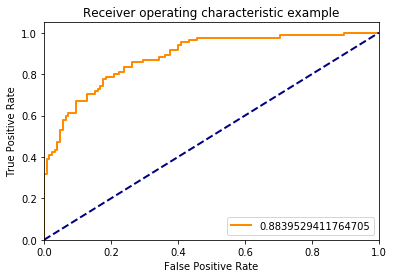

In [91]:
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2,
        label="{}".format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()